<a href="https://colab.research.google.com/github/Jotadebeese/Rubbish-Classifier-Updated/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with PyTorch

The following is the implementation of transfer learning for a Computer Vision classification application using torchvision.

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo, installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the PyTorch Scripts directory, download it from GitHub
try:
    from modular_scripts import data_setup, engine, utils
except:
    # Get the scripts
    print("[INFO] Couldn't find scripts, downloading them from GitHub.")
    !git clone https://github.com/Jotadebeese/pytorch_scripts
    !mv pytorch_scripts/modular_scripts .
    !rm -rf pytorch_scripts
    from modular_scripts import data_setup, engine, utils

[INFO] Couldn't find torchinfo, installing it.
[INFO] Couldn't find scripts, downloading them from GitHub.
Cloning into 'pytorch_scripts'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 87 (delta 44), reused 80 (delta 37), pack-reused 0
Receiving objects: 100% (87/87), 24.35 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Getting data using the function `get_data` from `utils.py`

In [3]:
image_path = utils.get_data(zip_file_id='17oNGRMw72dcTOhbm_H4Gu7GrCx_LPpVp')

'data/images_dataset' does not exist, creating directory...


Downloading...
From: https://drive.google.com/uc?id=17oNGRMw72dcTOhbm_H4Gu7GrCx_LPpVp
To: /content/data/dataset.zip
100%|██████████| 549M/549M [00:05<00:00, 102MB/s]


Unzipping data...


### 1.1 Converting Images to jpg format

Converting images to jpg using `image_convertor` from `utils`

In [4]:
# cardboard class convertion
utils.image_convertor(path="data/rubbish_dataset/cardboard/",
                    format="jpg")
# glass class convertion
utils.image_convertor(path="data/rubbish_dataset/glass/",
                    format="jpg")
# metal class convertion
utils.image_convertor(path="data/rubbish_dataset/metal/",
                    format="jpg")
# paper class convertion
utils.image_convertor(path="data/rubbish_dataset/paper/",
                    format="jpg")
# plastic class convertion
utils.image_convertor(path="data/rubbish_dataset/plastic/",
                      format="jpg")
# trash class convertion
utils.image_convertor(path="data/rubbish_dataset/trash/",
                      format="jpg")

492it [00:03, 147.75it/s]


66 images converted to 'jpg' in 'data/rubbish_dataset/cardboard'


772it [00:01, 488.18it/s]


42 images converted to 'jpg' in 'data/rubbish_dataset/glass'


672it [00:00, 79805.55it/s]


0 images converted to 'jpg' in 'data/rubbish_dataset/metal'


743it [00:00, 63837.76it/s]


0 images converted to 'jpg' in 'data/rubbish_dataset/paper'


632it [00:00, 105240.60it/s]


0 images converted to 'jpg' in 'data/rubbish_dataset/plastic'


456it [00:07, 62.84it/s]

125 images converted to 'jpg' in 'data/rubbish_dataset/trash'


### 1.2 Spliting Data into train, validation and test

Using `split folders`

Source: https://github.com/jfilter/split-folders

In [5]:
# get split-folders ready to use
import shutil

try:
    import splitfolders
except:
    !pip install split-folders[full]
    import splitfolders

# Define input and output folders
input_folder = "data/rubbish_dataset"
output_folder = str(image_path)

splitfolders.ratio(input_folder, output=output_folder,
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

shutil.rmtree(input_folder)

Copying files: 3767 files [00:01, 2692.63 files/s]


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"

train_dir, test_dir, val_dir

(PosixPath('data/images_dataset/train'),
 PosixPath('data/images_dataset/test'),
 PosixPath('data/images_dataset/val'))

## 2. Create Datasets and DataLoaders

To do so, we use `data_setup.py` and the `create_dataLoaders()` inside it.

In [7]:
from modular_scripts import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize image to 224, 224
    transforms.ToTensor(), # get into range [0, 1]
    normalize # Make sure images have the same distribution as ImageNet dataset
])

In [9]:
train_dataLoader, test_dataLoader, class_names = data_setup.create_dataLoaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataLoader, test_dataLoader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bb456613bb0>,
 ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create the pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create DataLoaders using automatic transforms
train_dataLoader, test_dataLoader, class_names = data_setup.create_dataLoaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)
train_dataLoader, test_dataLoader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bb456611de0>,
 ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:

1. PyTorch domain libraries.
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Setting up a pretrained model

In [13]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
  kwargs.pop("check_hash")
  return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s] 


### 3.2 Getting a summary of the model with `torchinfo.summary()`



In [14]:
# Print summary
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [15]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [16]:
# Update the classifier head of our model to suit our problem
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=6, bias=True)
)

In [17]:
summary(model=model,
        input_size=(1, 3, 224, 224), # [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 6]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Train Model

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Import train function
from modular_scripts import engine

# Set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataLoader,
                       test_dataloader=test_dataLoader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out
end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3281 | train_acc: 0.5240 | test_loss: 0.9220 | test_acc: 0.7236
Epoch: 2 | train_loss: 0.9343 | train_acc: 0.6888 | test_loss: 0.7653 | test_acc: 0.7630
Epoch: 3 | train_loss: 0.8157 | train_acc: 0.7273 | test_loss: 0.7110 | test_acc: 0.7602
Epoch: 4 | train_loss: 0.7648 | train_acc: 0.7306 | test_loss: 0.6832 | test_acc: 0.7528
Epoch: 5 | train_loss: 0.7161 | train_acc: 0.7632 | test_loss: 0.6707 | test_acc: 0.7682
[INFO] Total training time: 363.904 seconds.


### 5. Evaluate model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


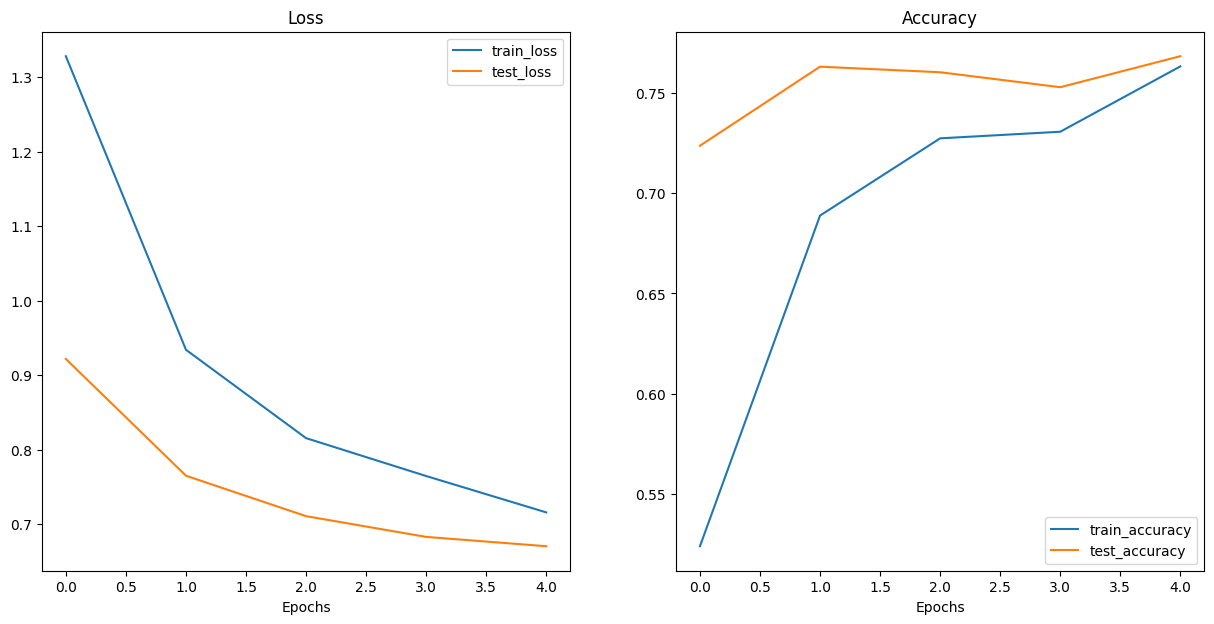

In [20]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Things to make sure:
* Same shape - Images need to be same shape as model was trained on.
* Same datatype - custom data should be same data type.
* Same device - custom data/test data should be on the same device as the model.
* Same transform.

Function `pred_and_plot_image()` steps:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.Open()`.
3. Create a transform is one doesn't exist.
4. Make sure the model is on the target devie.
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`).
6. Transform the target image and make sure its deimensionality is suited for the model (this mainly relates to batch size).
7. Make a prediction on the image by passing to the model.
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step nine and prediction probability from step 8.


In [44]:
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

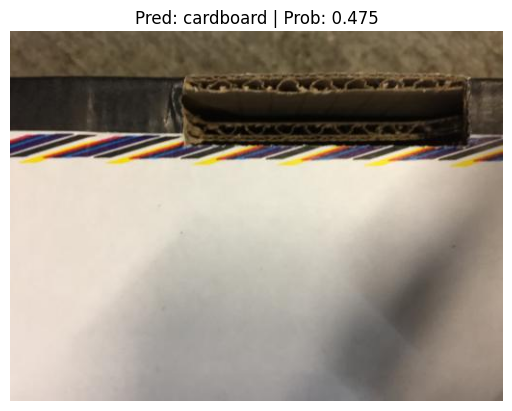

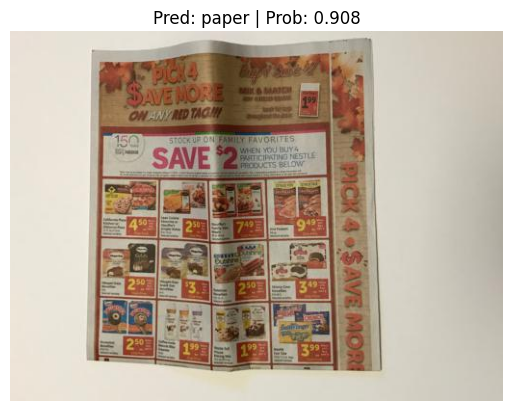

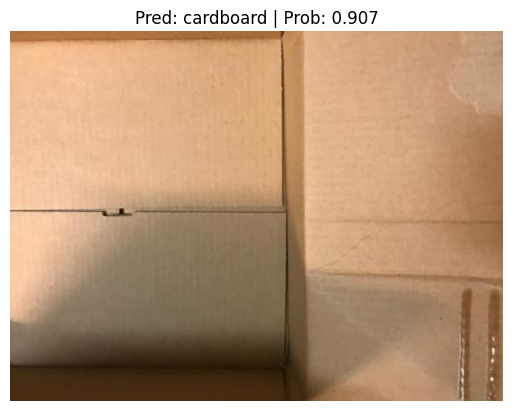

In [53]:
# Get a random list of image paths from the test set
import random
from pathlib import Path

num_images_to_plot = 3
val_image_path_list = list(Path(val_dir).glob("*/*.jpg"))
val_image_path_sample = random.sample(population=val_image_path_list,
                                      k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in val_image_path_sample:
  utils.pred_and_plot_image(model=model,
                            image_path=image_path,
                            class_names=class_names,
                            image_size=(224, 224))